Training on clean data:
Epoch 1/10, Loss: 2.3052, Accuracy: 9.00%
Epoch 2/10, Loss: 2.2819, Accuracy: 28.40%
Epoch 3/10, Loss: 2.2039, Accuracy: 47.65%
Epoch 4/10, Loss: 1.9797, Accuracy: 98.85%
Epoch 5/10, Loss: 1.5524, Accuracy: 100.00%
Epoch 6/10, Loss: 1.0039, Accuracy: 100.00%
Epoch 7/10, Loss: 0.5408, Accuracy: 100.00%
Epoch 8/10, Loss: 0.2775, Accuracy: 100.00%
Epoch 9/10, Loss: 0.1579, Accuracy: 100.00%
Epoch 10/10, Loss: 0.1013, Accuracy: 100.00%

Final Evaluation on Clean Data: 100.00%

Training on backdoor data:
Epoch 1/10, Loss: 0.2582, Accuracy: 95.50%
Epoch 2/10, Loss: 0.1842, Accuracy: 95.50%
Epoch 3/10, Loss: 0.1275, Accuracy: 95.50%
Epoch 4/10, Loss: 0.0851, Accuracy: 95.60%
Epoch 5/10, Loss: 0.0557, Accuracy: 99.40%
Epoch 6/10, Loss: 0.0375, Accuracy: 99.90%
Epoch 7/10, Loss: 0.0267, Accuracy: 99.95%
Epoch 8/10, Loss: 0.0198, Accuracy: 100.00%
Epoch 9/10, Loss: 0.0153, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0122, Accuracy: 100.00%

Final Evaluation on Clean Data (post

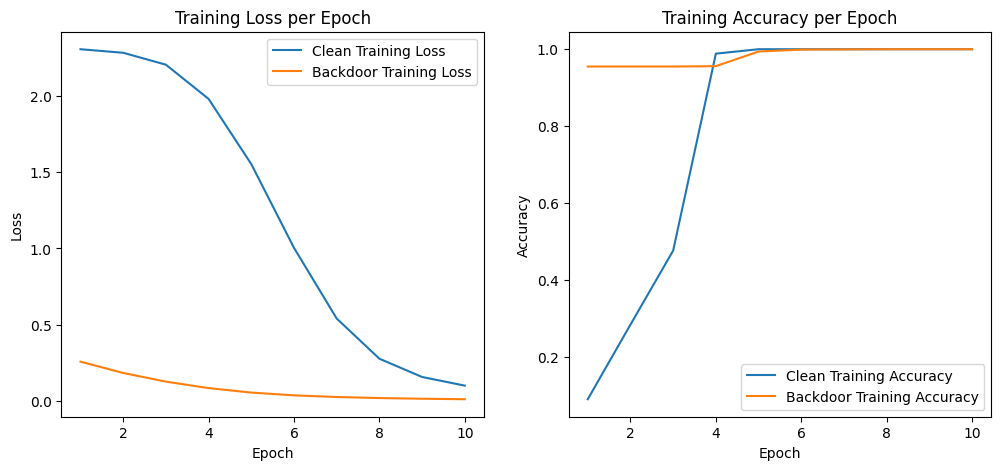

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Define the Gaussian kernel function
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * sigma**2))

# Compute the kernel matrix using the Gaussian kernel
def compute_kernel_matrix(data, sigma=1.0):
    n_samples = data.shape[0]
    kernel_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            kernel_matrix[i, j] = gaussian_kernel(data[i], data[j], sigma=sigma)
    return kernel_matrix

# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=len(dataset))
data, targets = next(iter(data_loader))
data = data.view(data.size(0), -1).numpy()  # Flatten images to vectors

# Use a subset for faster computation (e.g., 2000 samples)
data, _, targets, _ = train_test_split(data, targets.numpy(), train_size=2000, stratify=targets)

# Compute the kernel matrix
sigma = 1.0  # Adjust this parameter for the kernel width
kernel_matrix = compute_kernel_matrix(data, sigma=sigma)
kernel_matrix = torch.tensor(kernel_matrix, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.long)

# Define a simple neural network for classification
class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
input_dim = kernel_matrix.shape[1]
num_classes = 10
model = SimpleNN(input_dim, num_classes)

# Training function with result tracking
def train(model, kernel_matrix, targets, epochs=10, batch_size=32, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # For storing loss and accuracy per epoch
    loss_values = []
    accuracy_values = []
    
    # Convert data into DataLoader for batching
    dataset = TensorDataset(kernel_matrix, targets)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_data, batch_labels in data_loader:
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Calculate accuracy for this batch
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_labels).sum().item()
            total += batch_labels.size(0)
        
        # Store epoch loss and accuracy
        avg_loss = total_loss / len(data_loader)
        accuracy = correct / total
        loss_values.append(avg_loss)
        accuracy_values.append(accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    return loss_values, accuracy_values

# Evaluation function to calculate final accuracy
def test(model, kernel_matrix, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(kernel_matrix)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score(targets.numpy(), predicted.numpy())
    return accuracy

# Train the model on the clean dataset
print("Training on clean data:")
loss_clean, accuracy_clean = train(model, kernel_matrix, targets, epochs=10)

# Evaluate on clean data
accuracy_clean_final = test(model, kernel_matrix, targets)
print(f"\nFinal Evaluation on Clean Data: {accuracy_clean_final * 100:.2f}%")

# Backdoor attack: Modify a subset of targets
backdoor_indices = np.random.choice(len(targets), size=100, replace=False)
backdoor_targets = targets.clone()
backdoor_targets[backdoor_indices] = 0  # Set backdoor targets to class 0

# Retrain the model with the backdoor data
print("\nTraining on backdoor data:")
loss_backdoor, accuracy_backdoor = train(model, kernel_matrix, backdoor_targets, epochs=10)

# Evaluate on clean and backdoor data
accuracy_clean_after_backdoor = test(model, kernel_matrix, targets)
accuracy_backdoor_final = test(model, kernel_matrix, backdoor_targets)

print(f"\nFinal Evaluation on Clean Data (post-backdoor training): {accuracy_clean_after_backdoor * 100:.2f}%")
print(f"Final Evaluation on Backdoor Data: {accuracy_backdoor_final * 100:.2f}%")

# Plotting results
epochs = range(1, 11)

plt.figure(figsize=(12, 5))

# Plot loss values
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_clean, label="Clean Training Loss")
plt.plot(epochs, loss_backdoor, label="Backdoor Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()

# Plot accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_clean, label="Clean Training Accuracy")
plt.plot(epochs, accuracy_backdoor, label="Backdoor Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()

plt.show()
